# Análise Exploratória

In [1]:
# Importando as Bibliotecas
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.dates import DateFormatter
from matplotlib import ticker

## Inicialização Spark e carregamento dos dados

In [2]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Forecasting com Spark') \
    .getOrCreate()

spark

In [3]:
# Antes de carregar os dados, vamos explicitar a estrutura dos dados que
# serão carregados

schema = StructType([
    StructField('day_of_purchase', StringType(), False), # será carregado como string para posterior manipulação
    StructField('seller_id', StringType(), False),
    StructField('customer_id', StringType(), False),
    StructField('order_id', StringType(), False),
    StructField('order_status', StringType(), False),
    StructField('order_item_id', IntegerType(), False),
    StructField('product_id', StringType(), False),
    StructField('product_category_name', StringType(), False),
    StructField('price', DoubleType(), False),
    StructField('freight_value', DoubleType(), False),
    StructField('customer_city', StringType(), False),
    StructField('customer_state', StringType(), False),
    StructField('seller_city', StringType(), False),
    StructField('seller_state', StringType(), False)
])

In [4]:
#Importando os dados
path_csv = '../dados/forecast_query.csv'

df = spark.read.csv(
    path_csv,
    inferSchema=True,
    header=True,
    schema=schema
)

## Compreensão dos Dados

In [5]:
# Verificando se os tipos foram determinados corretamente de acordo com o 
# struct type previamente definido
df.printSchema()

root
 |-- day_of_purchase: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- seller_city: string (nullable = true)
 |-- seller_state: string (nullable = true)



In [6]:
# Visualizar as primeiras cinco linhas do Spark Dataframe
df.limit(5).toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,customer_state,seller_city,seller_state
0,2016-09-04 21:15:19,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,1,c1488892604e4ba5cff5b4eb4d595400,moveis_decoracao,39.99,31.67,boa vista,RR,monte siao,MG
1,2016-09-04 21:15:19,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2,f293394c72c9b5fafd7023301fc21fc2,moveis_decoracao,32.90,31.67,boa vista,RR,monte siao,MG
2,2016-09-15 12:16:38,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,1,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR
3,2016-09-15 12:16:38,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR
4,2016-09-15 12:16:38,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,3,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR


In [7]:
# Verificando quantos registros temos no dataset
print('Quantidade de vendas:', df.count())

Quantidade de vendas: 112108


In [8]:
# Verificando se existen colunas com valores nulos
df.select(
    [f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) 
        for c in df.columns]

).toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,customer_state,seller_city,seller_state
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Separação dos Dados

In [9]:
# Transformar a coluna `data_of_purchase` para o tipo data (vamos aproveitar somente a data, a hora por enquanto vamos descartar)

df = df.withColumn('day_of_purchase', f.to_date(df['day_of_purchase']))
df.limit(5).toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,customer_state,seller_city,seller_state
0,2016-09-04,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,1,c1488892604e4ba5cff5b4eb4d595400,moveis_decoracao,39.99,31.67,boa vista,RR,monte siao,MG
1,2016-09-04,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2,f293394c72c9b5fafd7023301fc21fc2,moveis_decoracao,32.90,31.67,boa vista,RR,monte siao,MG
2,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,1,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR
3,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR
4,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,3,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR


In [10]:
# Vamos verificar qual é o intervalo do nosso dataset

df\
    .select(f.min('day_of_purchase').alias('first_date'), 
            f.max('day_of_purchase').alias('last_date'),
            f.datediff(f.max('day_of_purchase'), 
                        f.min('day_of_purchase')).alias('interval_days'))\
    .toPandas()

,first_date,last_date,interval_days
0,2016-09-04,2018-09-03,729


O dataset compreende um período de 2 anos, ou 24 meses.   
Vamos analizar o comportamento dos primeiros 18 meses, entender os padrões desse intervalo e modelar o nosso caso.  
O restante será utilizado para validarmos o resultado.

In [11]:
df\
    .select(f.min('day_of_purchase').alias('first_date'), 
            f.add_months(f.min('day_of_purchase'), 18).alias('cut_off_date'))\
    .show()

+----------+------------+
|first_date|cut_off_date|
+----------+------------+
|2016-09-04|  2018-03-04|
+----------+------------+



In [12]:
df_analise = df\
    .select('*')\
    .where('day_of_purchase < "2018-03-04"')

df_validacao = df\
    .select('*')\
    .where('day_of_purchase >= "2018-03-04"')

In [13]:
df_analise.toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,customer_state,seller_city,seller_state
0,2016-09-04,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,1,c1488892604e4ba5cff5b4eb4d595400,moveis_decoracao,39.99,31.67,boa vista,RR,monte siao,MG
1,2016-09-04,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2,f293394c72c9b5fafd7023301fc21fc2,moveis_decoracao,32.90,31.67,boa vista,RR,monte siao,MG
2,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,1,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR
3,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR
4,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,3,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,SP,curitiba,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67580,2018-03-03,d2374cbcbb3ca4ab1086534108cc3ab7,25a52f95724799f5b375932dfb65c5f7,b37d46f83322f86eae75b766a515cffe,delivered,1,0152f69b6cf919bcdaf117aa8c43e5a2,cama_mesa_banho,13.90,34.15,joao pessoa,PB,ibitinga,SP
67581,2018-03-03,e62b2d6ac10570a035a30bafcf01d263,85f4e1a23fa6be40331706e9eebbdaa1,d6235477014458ade86158040370fca8,delivered,1,6bbe55cf8f85c87b6eebb775a53402f4,tablets_impressao_imagem,53.49,8.72,sao paulo,SP,sao paulo,SP
67582,2018-03-03,8b321bb669392f5163d04c59e235e066,5cd812c5b28b235cfb60b9e5a194bd7c,37660ed0022803717d2eb7bac4300621,delivered,1,75b433ca888fe027b18dfac89a284667,eletronicos,12.90,7.78,osasco,SP,sao paulo,SP
67583,2018-03-03,7c67e1448b00f6e969d365cea6b010ab,a5acb5aeca07d29dc93bef57f887b1fe,fce11c1012b2c4e62437daaf24cf96a7,delivered,1,759d6e247dae636cc8e135f50052865e,moveis_escritorio,149.99,45.51,ipatinga,MG,itaquaquecetuba,SP


In [14]:
df_validacao.toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,customer_state,seller_city,seller_state
0,2018-03-04,abcd2cb37d46c2c8fb1bf071c859fc5b,078dbbc73431f0553f696d0913e99ac0,7616b98483a2f8af40e3ab4d8ef3ffc9,delivered,1,6d81453f00fb94345c02d87149c52f00,beleza_saude,71.50,14.25,campo grande,MS,cuiaba,MT
1,2018-03-04,9e6229250fedbe05838fef417b74e7fb,c0314850cd5254ebcc66a4b00acd306c,f3bf8da6fd4b735f85852c38ca15e90e,delivered,1,9751b280db38705e0225fcbad03d17cc,moveis_decoracao,239.90,18.39,guarulhos,SP,mirandopolis,SP
2,2018-03-04,bf84056e679dbe9c69929847a40e338f,5b68d641f6f6cf9920a7010d6a7cd755,565d193549c110156821ab4e05cb6240,delivered,1,437c05a395e9e47f9762e677a7068ce7,beleza_saude,49.89,7.78,sao paulo,SP,sao paulo,SP
3,2018-03-04,7c67e1448b00f6e969d365cea6b010ab,69de6e98cbd456c73122e8fd3a20554d,0c1131dcb8c6ec0c895af6aea3e70983,delivered,1,2a5806f10d0f00e5ad032dd2e3c8806e,moveis_escritorio,169.99,48.11,fortaleza,CE,itaquaquecetuba,SP
4,2018-03-04,ce248b21cb2adc36282ede306b7660e5,25c6b9cdce83cd1359c01f00b9b239be,3657d83f0ccdda70b89b5ae9e6fdb07c,delivered,1,b5285354b7300aa056db9c3b73e50cd0,instrumentos_musicais,72.90,18.08,paracambi,RJ,jaragua do sul,SC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44518,2018-08-29,67bf6941ba2f1fa1d02c375766bc3e53,e60df9449653a95af4549bbfcb18a6eb,0b223d92c27432930dfe407c6aea3041,delivered,2,2b4472df15512a2825ae86fd9ae79335,moveis_cozinha_area_de_servico_jantar_e_jardim,209.00,46.48,curitiba,PR,curitiba,PR
44519,2018-08-29,2a84855fd20af891be03bc5924d2b453,6e353700bc7bcdf6ebc15d6de16d7002,168626408cb32af0ffaf76711caae1dc,delivered,1,bdcf6a834e8faa30dac3886c7a58e92e,beleza_saude,45.90,15.39,paracatu,MG,belo horizonte,MG
44520,2018-08-29,7d7866a99a8656a42c7ff6352a433410,496630b6740bcca28fce9ba50d8a26ef,03ef5dedbe7492bdae72eec50764c43f,delivered,1,c7f27c5bef2338541c772b5776403e6a,artigos_de_festas,24.90,8.33,sao caetano do sul,SP,sao paulo,SP
44521,2018-08-29,9f505651f4a6abe901a56cdc21508025,898b7fee99c4e42170ab69ba59be0a8b,35a972d7f8436f405b56e36add1a7140,delivered,1,d04857e7b4b708ee8b8b9921163edba3,informatica_acessorios,84.99,8.76,limeira,SP,sao paulo,SP


A partir deste ponto toda a análise será realizada no `df_analise`.

### Analisando os Dados  
Neste tópico vamos explorar mais as features presentes no nosso dataset.

#### Dados categóricos  

##### Categoria do produto

In [15]:
# Verificando qtas categorias de produto o dataset possui
df_analise\
    .select(f.count_distinct('product_category_name').alias('qtd categorias'))\
    .show()


+--------------+
|qtd categorias|
+--------------+
|            73|
+--------------+



Existem várias categorias neste dataset, e talvez não seja viável trabalharmos com todos eles.  
Vamos investigar melhor as categorias para vermos se podemos refinar as pesquisas.

In [16]:
# Criando os totais para realizar comparações.
total_item = df_analise.count()
sum_price = df_analise.select('price').agg(f.sum('price').alias('total')).toPandas()

sum_price = int(sum_price['total'])

total_item, sum_price

(67585, 8035827)

In [17]:
# Ordenando por quantidade de produtos
df_analise\
    .select('price', 'product_category_name')\
    .groupBy('product_category_name')\
    .agg(
        f.round(f.sum('price'), 2).alias('total_preco'),
        f.round(f.sum('price') / sum_price, 2).alias('pct_total_preco'),
        f.count('product_category_name').alias('qtd_produtos'),
        (f.count('product_category_name') / total_item).alias('pct_qtd_produtos')
    )\
    .orderBy('qtd_produtos', ascending=False)\
    .limit(20)\
    .toPandas()


,product_category_name,total_preco,pct_total_preco,qtd_produtos,pct_qtd_produtos
0,cama_mesa_banho,642199.27,0.08,6836,0.101147
1,esporte_lazer,622620.35,0.08,5447,0.080595
2,moveis_decoracao,442009.02,0.06,5301,0.078435
3,beleza_saude,656777.17,0.08,5074,0.075076
4,informatica_acessorios,593870.18,0.07,4873,0.072102
5,utilidades_domesticas,306058.72,0.04,3681,0.054465
6,ferramentas_jardim,323455.06,0.04,3013,0.044581
7,relogios_presentes,636369.77,0.08,3011,0.044551
8,telefonia,172494.04,0.02,2957,0.043752
9,brinquedos,348749.50,0.04,2940,0.043501


In [18]:
# Ordenando pelo preco do produto

df_analise\
    .select('price', 'product_category_name')\
    .groupBy('product_category_name')\
    .agg(
        f.round(f.sum('price'), 2).alias('total_preco'),
        f.round(f.sum('price') / sum_price, 2).alias('pct_total_preco'),
        f.count('product_category_name').alias('qtd_produtos'),
        (f.count('product_category_name') / total_item).alias('pct_qtd_produtos')
    )\
    .orderBy('total_preco', ascending=False)\
    .limit(20)\
    .toPandas()


,product_category_name,total_preco,pct_total_preco,qtd_produtos,pct_qtd_produtos
0,beleza_saude,656777.17,0.08,5074,0.075076
1,cama_mesa_banho,642199.27,0.08,6836,0.101147
2,relogios_presentes,636369.77,0.08,3011,0.044551
3,esporte_lazer,622620.35,0.08,5447,0.080595
4,informatica_acessorios,593870.18,0.07,4873,0.072102
5,cool_stuff,463440.00,0.06,2824,0.041784
6,moveis_decoracao,442009.02,0.06,5301,0.078435
7,brinquedos,348749.50,0.04,2940,0.043501
8,ferramentas_jardim,323455.06,0.04,3013,0.044581
9,automotivo,320258.15,0.04,2207,0.032655


Apesar de existir vários tipos de produtos, aparentemente os valores estão bem distribuiídos - por enquanto vamos manter dessa forma.  
Ao ordenar pela quantidade, notamos que existe uma categoria de produto que está como NULL.  
Provavelmente saiu assim quando realizamos a query no banco. Vamos deletar esses itens futuramente.

#### Tratando a categoria de produto Nula

In [19]:
df_analise \
    .select('product_category_name', 'price')\
    .where(df['product_category_name'] == 'NULL')\
    .agg(
        f.count('product_category_name').alias('qtd_itens_nulos'),
        f.sum('price').alias('soma_precos_nulos')
    )\
    .toPandas()

,qtd_itens_nulos,soma_precos_nulos
0,1245,141697.97


In [20]:
# Pegando o valor total das vendas

df_analise.select(f.sum('price').alias('total price')).show(truncate=False)

+-----------------+
|total price      |
+-----------------+
|8035827.099999206|
+-----------------+



In [21]:
print((1249 / 67835) * 100)
print((178572.55 / 8035827.099999206) * 100)

1.8412324021522812
2.2222049799953716


Como se trata se um uma proporção pequena, vamos simplismente dropar esses registros.

In [22]:
df_analise = df_analise.filter(df_analise['product_category_name'] != 'NULL')
df_validacao = df_validacao.filter(df_validacao['product_category_name'] != 'NULL')

In [23]:
df_analise\
    .select('*')\
    .where(df_analise['product_category_name'] == 'NULL')\
    .show()

+---------------+---------+-----------+--------+------------+-------------+----------+---------------------+-----+-------------+-------------+--------------+-----------+------------+
|day_of_purchase|seller_id|customer_id|order_id|order_status|order_item_id|product_id|product_category_name|price|freight_value|customer_city|customer_state|seller_city|seller_state|
+---------------+---------+-----------+--------+------------+-------------+----------+---------------------+-----+-------------+-------------+--------------+-----------+------------+
+---------------+---------+-----------+--------+------------+-------------+----------+---------------------+-----+-------------+-------------+--------------+-----------+------------+



In [24]:
# Ordenando por quantidade de produtos
df_analise\
    .select('price', 'product_category_name')\
    .groupBy('product_category_name')\
    .agg(
        f.round(f.sum('price'), 2).alias('total_preco'),
        f.round(f.sum('price') / sum_price, 2).alias('pct_total_preco'),
        f.count('product_category_name').alias('qtd_produtos'),
        (f.count('product_category_name') / total_item).alias('pct_qtd_produtos')
    )\
    .orderBy('qtd_produtos', ascending=False)\
    .limit(20)\
    .toPandas()

,product_category_name,total_preco,pct_total_preco,qtd_produtos,pct_qtd_produtos
0,cama_mesa_banho,642199.27,0.08,6836,0.101147
1,esporte_lazer,622620.35,0.08,5447,0.080595
2,moveis_decoracao,442009.02,0.06,5301,0.078435
3,beleza_saude,656777.17,0.08,5074,0.075076
4,informatica_acessorios,593870.18,0.07,4873,0.072102
5,utilidades_domesticas,306058.72,0.04,3681,0.054465
6,ferramentas_jardim,323455.06,0.04,3013,0.044581
7,relogios_presentes,636369.77,0.08,3011,0.044551
8,telefonia,172494.04,0.02,2957,0.043752
9,brinquedos,348749.50,0.04,2940,0.043501


#### Cidades do comprador/vendedor  
Vamos verificar a distribuição das cidades nas operações, tanto do comprador como vendedor.

In [25]:
df_analise\
    .select(
        f.countDistinct('customer_city').alias('cidade_cliente'),
        f.count_distinct('seller_city').alias('cidade_fornecedor'))\
    .show()

+--------------+-----------------+
|cidade_cliente|cidade_fornecedor|
+--------------+-----------------+
|          3589|              465|
+--------------+-----------------+



In [26]:
# Quais são as cidades que mais concentram clientes?

df_analise\
    .groupBy('customer_city')\
    .agg(
        f.count('customer_city').alias('cidade')
    )\
    .orderBy('cidade', ascending=False)\
    .limit(10)\
    .toPandas()

,customer_city,cidade
0,sao paulo,9578
1,rio de janeiro,4935
2,belo horizonte,1816
3,brasilia,1375
4,curitiba,1023
5,porto alegre,990
6,campinas,926
7,salvador,811
8,guarulhos,702
9,sao bernardo do campo,596


In [27]:
# Quais são as cidades que mais concentram fornecedores?

df_analise\
    .groupBy('seller_city')\
    .agg(
        f.count('seller_city').alias('cidade')
    )\
    .orderBy('cidade', ascending=False)\
    .limit(10)\
    .toPandas()

,seller_city,cidade
0,sao paulo,16186
1,ibitinga,5065
2,santo andre,2109
3,curitiba,1830
4,sao jose do rio preto,1751
5,belo horizonte,1600
6,maringa,1394
7,rio de janeiro,1277
8,ribeirao preto,1247
9,piracicaba,1215


Parece que a maior parte dos compradores e vendedores se concentram na regiao sudeste, mas para confirmarmos essa hipótese vamos realizar a mesma tabela mas agora com o estado.

In [28]:
df\
    .groupBy('customer_state')\
    .agg(
        f.sum('price').alias('total_vendas'),
        f.count('order_id').alias('qtd_vendas')
    )\
    .orderBy('total_vendas', ascending=False)\
    .toPandas()

,customer_state,total_vendas,qtd_vendas
0,SP,5165166.12,47156
1,RJ,1811923.32,14510
2,MG,1573667.19,13073
3,RS,742809.68,6212
4,PR,676883.06,5719
5,SC,518578.28,4161
6,BA,507108.83,3785
7,DF,300886.45,2397
8,GO,287870.46,2323
9,ES,273532.13,2248


In [29]:
df\
    .groupBy('seller_state')\
    .agg(
        f.sum('price').alias('total_vendas'),
        f.count('order_id').alias('qtd_vendas')
    )\
    .orderBy('total_vendas', ascending=False)\
    .toPandas()

,seller_state,total_vendas,qtd_vendas
0,SP,8.687874e+06,79947
1,PR,1.256874e+06,8638
2,MG,1.001945e+06,8774
3,RJ,8.380162e+05,4796
4,SC,6.252020e+05,4051
5,RS,3.777269e+05,2193
6,BA,2.853326e+05,641
7,DF,9.710048e+04,896
8,PE,9.146395e+04,447
9,GO,6.625172e+04,517


In [30]:
# Criando dataframe do pandas para poder plotar os gráficos.

pandas_compras_clientes = df\
    .groupBy('customer_state')\
    .agg(
        f.sum('price').alias('total_vendas'),
        f.count('order_id').alias('qtd_vendas')
    )\
    .orderBy('total_vendas', ascending=False)\
    .toPandas()

pandas_vendas_fornecedor = df\
    .groupBy('seller_state')\
    .agg(
        f.sum('price').alias('total_vendas'),
        f.count('order_id').alias('qtd_vendas')
    )\
    .orderBy('total_vendas', ascending=False)\
    .toPandas()

In [31]:
# Dividindo por milhar para poder facilitar a visualização.

pandas_compras_clientes['total_vendas_k'] = pandas_compras_clientes['total_vendas'] / 1000
pandas_vendas_fornecedor['total_vendas_k'] = pandas_vendas_fornecedor['total_vendas'] / 1000


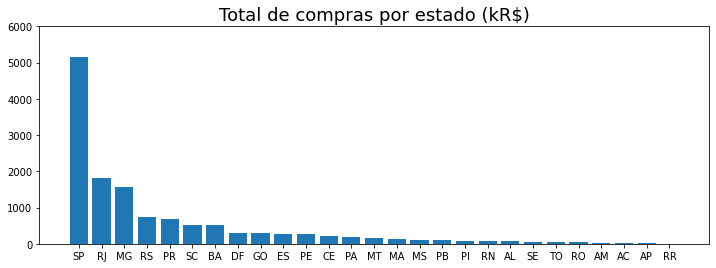

In [32]:
plt.figure(figsize=(12, 4))
plt.title('Total de compras por estado (kR$)', fontsize=18)
plt.bar(x='customer_state', height='total_vendas_k', data=pandas_compras_clientes)
plt.yticks(np.arange(0, 6001, 1000))
plt.show()

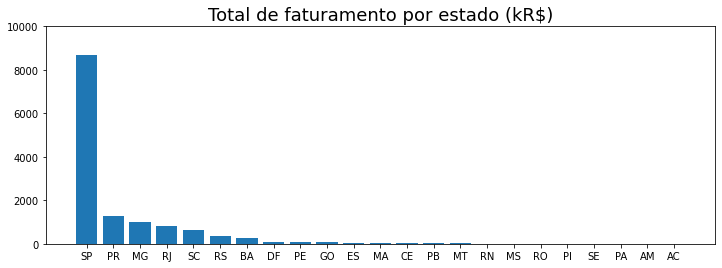

In [33]:
plt.figure(figsize=(12, 4))
plt.title('Total de faturamento por estado (kR$)', fontsize=18)
plt.bar(x='seller_state', height='total_vendas_k', data=pandas_vendas_fornecedor)
plt.yticks(np.arange(0, 10001, 2000))
plt.show()

Podemos observar que tanto compradores como vendedores estão concentrados na região sul/sudeste, com destaque para o estado de São Paulo.  
Talvez na hora de modelar, pode ser interessante **separar a predição por estado** para tentar resultados mais consistentes.

#### Comportamento de vendas através do tempo
Vamos analizar o comportamento de vendas através do tempo.

In [34]:
# Criando um dataframe do pandas para podermos plotar alguns gráficos
df_pandas_serie_temporal = df_analise.toPandas()

# Determinando a data da compras como o índice do dataframe
df_pandas_serie_temporal = df_pandas_serie_temporal.set_index('day_of_purchase')
df_pandas_serie_temporal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66340 entries, 2016-09-04 to 2018-03-03
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   seller_id              66340 non-null  object 
 1   customer_id            66340 non-null  object 
 2   order_id               66340 non-null  object 
 3   order_status           66340 non-null  object 
 4   order_item_id          66340 non-null  int32  
 5   product_id             66340 non-null  object 
 6   product_category_name  66340 non-null  object 
 7   price                  66340 non-null  float64
 8   freight_value          66340 non-null  float64
 9   customer_city          66340 non-null  object 
 10  customer_state         66340 non-null  object 
 11  seller_city            66340 non-null  object 
 12  seller_state           66340 non-null  object 
dtypes: float64(2), int32(1), object(10)
memory usage: 6.8+ MB


In [35]:
# Uma primeira visualização das vendas agrupadas por dia
df_pandas_serie_temporal.groupby(df_pandas_serie_temporal.index).sum('price')[['price']]

,price
day_of_purchase,
2016-09-04,72.89
2016-09-15,134.97
2016-10-03,441.98
2016-10-04,9521.17
2016-10-05,8214.55
...,...
2018-02-27,39747.45
2018-02-28,45337.29
2018-03-01,38920.07


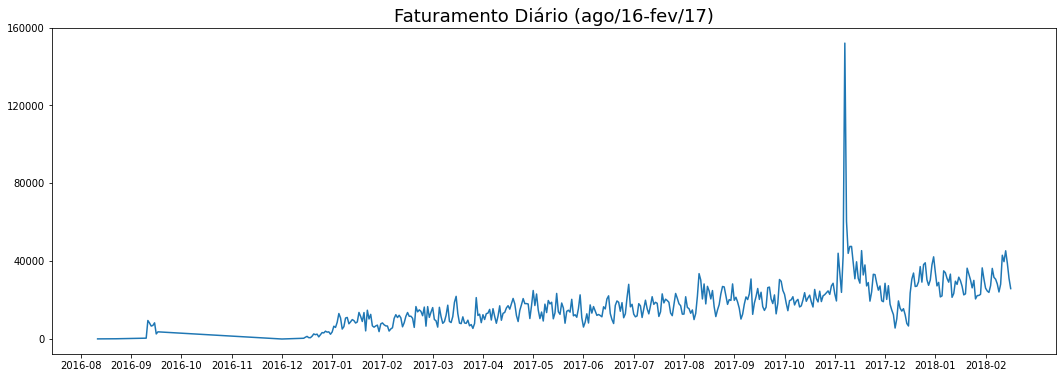

In [36]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Faturamento Diário (ago/16-fev/17)', fontsize=18)
plt.plot(df_pandas_serie_temporal.groupby(df_pandas_serie_temporal.index).sum('price')[['price']])

ax.set_yticks(np.arange(0, 16e4 + 1, 4e4))

ax.xaxis.set_major_locator(ticker.IndexLocator(base=30, offset=-10))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))


Com as vendas agrupadas no dia ainda está difícil identificar um padrão, sem mencionar o pico agudo que existe no mes de novembro/17.  
Outro ponto que vale mencionar é que as vendas de 2016 pode não ajudar na modelagem, já que possui poucas vendas.

In [37]:
# Verificando quais foram os dias com os maiores faturamento
# percebe-se que noos maiores valores são do final de novembro de 2017.

df_pandas_serie_temporal.groupby(df_pandas_serie_temporal.index).sum('price')['price'].sort_values(ascending=False)

day_of_purchase
2017-11-24    152050.89
2017-11-25     60471.12
2017-11-28     47576.92
2017-11-27     47561.39
2017-12-04     45424.73
                ...    
2016-10-03       441.98
2017-01-05       396.90
2016-09-15       134.97
2016-09-04        72.89
2016-12-23        10.90
Name: price, Length: 434, dtype: float64

In [38]:
df_analise\
    .select('*')\
    .groupBy(f.year('day_of_purchase').alias('year'))\
    .agg(
        f.count(f.year('day_of_purchase')).alias('count'),
        f.format_number((f.sum('price') / 1000), 2).alias('total_sales')
    )\
    .toPandas()


,year,count,total_sales
0,2016,353,46.67
1,2017,49710,"6,003.26"
2,2018,16277,"1,844.20"


Nota-se portanto que o ano de 2016 não possui quantidade de dados suficientes e até prejudicaria na modelagem - portanto ela será descartada.  
Dessa forma, vamos precisar organizar novamente os dataframe spark `df_analise` e `df_validacao`.  
Podemos notar que o pico acontece no dia 24/11, arrastando um pouco o valor até o dia 25.  
Realizando uma [pesquisa](https://www.guiadasemana.com.br/compras/evento/black-friday-brasil-2017-2017-11-24) na internet podemos notar que esse dia se trata da blackfriday daquele ano, logo é compreensível que as vendas desse dia fosse especialemente alta.  
Para tentar atenuar essa variação, vamos criar uma coluna para indicar se uma data teve um evento especial, como o feriados.  

In [39]:
df_novo = df\
    .select('*')\
    .where('day_of_purchase > "2016-12-31"')

df_novo\
    .select(
        f.min('day_of_purchase').alias('first_date'), 
        f.max('day_of_purchase').alias('last_date'),
        f.datediff(f.max('day_of_purchase'), 
        f.min('day_of_purchase')).alias('interval_days')
    )\
    .toPandas()

,first_date,last_date,interval_days
0,2017-01-05,2018-09-03,606


In [40]:
# Como 606 dias dá aproximadamente 20 meses, 70% disso são 14 meses (ou 420 dias).
# Query para verificar qual seria o novo cut off

df_novo\
    .select(
        f.min('day_of_purchase').alias('first_date'),        
    )\
    .select(
        'first_date',
        f.date_add('first_date', 420).alias('new_cut_off'))\
    .show()

+----------+-----------+
|first_date|new_cut_off|
+----------+-----------+
|2017-01-05| 2018-03-01|
+----------+-----------+



In [41]:
df_analise_novo = df_novo\
    .select('*')\
    .where('day_of_purchase < "2018-03-01"')

df_validacao_novo = df_novo\
    .select('*')\
    .where('day_of_purchase >= "2018-03-01"')

Analisando novamente o comportamento das vendas diárias:

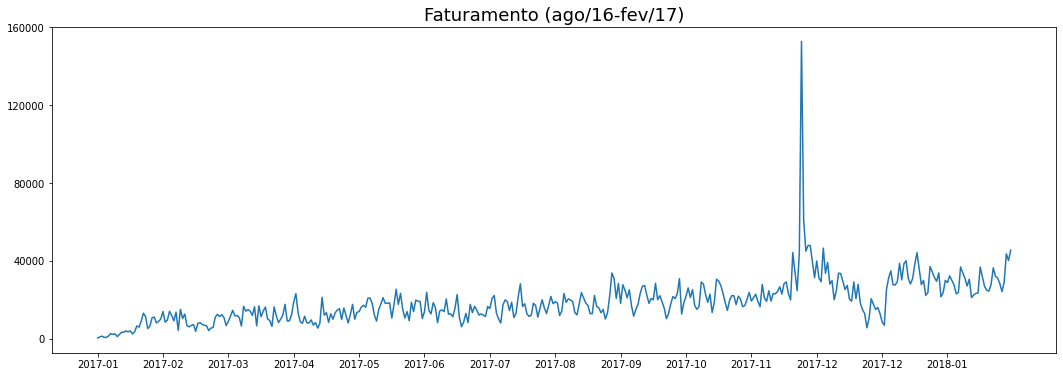

In [42]:
df_pandas_serie_temporal_novo = df_analise_novo.toPandas()
df_pandas_serie_temporal_novo = df_pandas_serie_temporal_novo.set_index('day_of_purchase')

df_pandas_serie_temporal_novo = df_pandas_serie_temporal_novo.groupby(df_pandas_serie_temporal_novo.index).sum('price')

fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Faturamento (ago/16-fev/17)', fontsize=18)
plt.plot(df_pandas_serie_temporal_novo[['price']])

ax.set_yticks(np.arange(0, 16e4 + 1, 4e4))

ax.xaxis.set_major_locator(ticker.IndexLocator(base=30, offset=-30))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))


Vamos verificar também outras características sobre as datas:  


##### Dias da semana

In [43]:
# O método dayofweek do sql.function mostra o dia da semana em numerais
# onde 1 representa domingo e 7 sábado

df_day_of_week = df_analise_novo\
    .withColumn('dayofweek', f.dayofweek('day_of_purchase'))\
    .groupBy('dayofweek')\
    .agg(
        f.count('order_id').alias('qtd_vendas'),
        f.sum('price').alias('total_vendas')
    )\
    .orderBy('dayofweek')\
    .toPandas()

df_day_of_week = df_day_of_week.set_index('dayofweek')

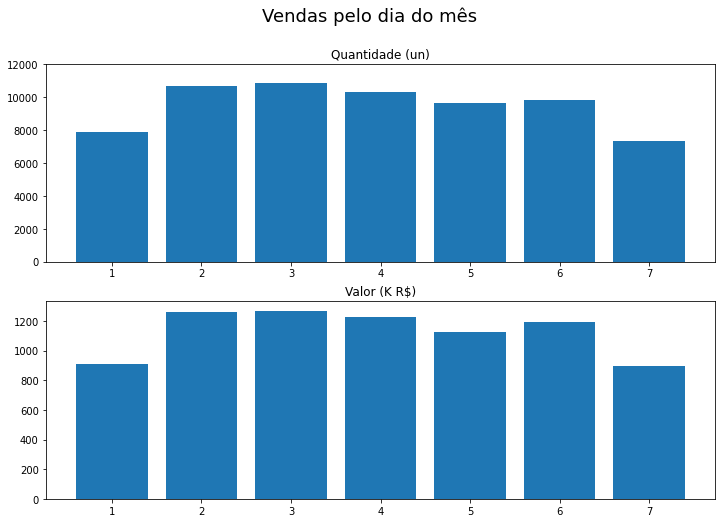

In [44]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

plt.suptitle('Vendas pelo dia do mês', fontsize=18)

ax1.set_title('Quantidade (un)')
ax1.bar(x=df_day_of_week.index, height=df_day_of_week['qtd_vendas'])
ax1.yaxis.set_ticks(np.arange(0, 12001, 2000))
ax1.xaxis.set_ticks(np.arange(1, 8, 1))


ax2.set_title('Valor (K R$)')
ax2.bar(x=df_day_of_week.index, height=(df_day_of_week['total_vendas'] / 1000))
ax2.yaxis.set_ticks(np.arange(0, 1201, 200))
ax2.xaxis.set_ticks(np.arange(1, 8, 1))

plt.show()


Podemos notar que as os dias úteis da semana concentram a uma quantidade maior de faturamento.

##### Dias do mês

In [45]:
df_day_of_month = df_analise_novo\
    .withColumn('dayofmonth', f.dayofmonth('day_of_purchase'))\
    .groupBy('dayofmonth')\
    .agg(
        f.count('order_id').cast(IntegerType()).alias('qtd_vendas'),
        f.sum('price').alias('total_vendas')
    )\
    .orderBy('dayofmonth')\
    .toPandas()

df_day_of_month = df_day_of_month.set_index('dayofmonth')

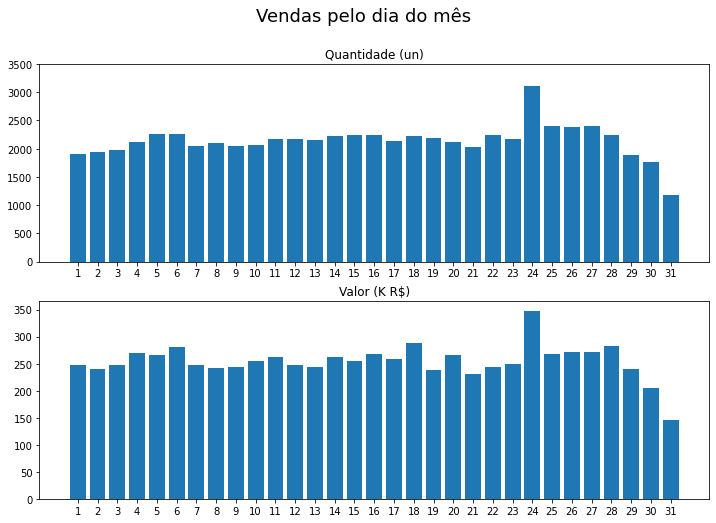

In [46]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

plt.suptitle('Vendas pelo dia do mês', fontsize=18)

ax1.set_title('Quantidade (un)')
ax1.bar(x=df_day_of_month.index, height=df_day_of_month['qtd_vendas'])
ax1.yaxis.set_ticks(np.arange(0, 3501, 500))
ax1.xaxis.set_ticks(np.arange(1, 32, 1))


ax2.set_title('Valor (K R$)')
ax2.bar(x=df_day_of_month.index, height=(df_day_of_month['total_vendas'] / 1000))
ax2.yaxis.set_ticks(np.arange(0, 351, 50))
ax2.xaxis.set_ticks(np.arange(1, 32, 1))

plt.show()


Não parece haver algum padrão de consumo, como no fim do mês haver mais vendas. O pico de vendas no dia 24 é por conta desse dia no mês de Novembro.

#### Impacto dos feriados  
Um ponto importante que não podemos deixar de avaliar é o se algumas datas podem impactar no comportamento de vendas, como os feriados por exemplo.  
Primeiro, vamos plotar apenas os feriados nacionais.

In [47]:
# Feriados nacionais e pontos facultativos de:
# 2017: https://www.feriados.com.br/feriados-nacionais/feriados-2017.php#:~:text=Feriados%20Nacionais%20em%202017%20Os%20Feriados%20Nacionais%20e,de%20mar%C3%A7o%20%28ponto%20facultativo%20at%C3%A9%20as%2014%20horas%29%3B
# 2018: 

feriados_nacionais_2017 = ['2017-01-01', '2017-02-27', '2017-02-28', 
                            '2017-03-01', '2017-04-14', '2017-04-21', 
                            '2017-05-01', '2017-06-15', '2017-09-07', 
                            '2017-10-12', '2017-10-28', '2017-11-02', 
                            '2017-11-15', '2017-12-15']

# feriados_nacionais_2018 = ['2018-01-01', '2018-02-12', '2018-02-13', 
#                             '2018-02-14', '2018-03-30', '2018-04-21', 
#                             '2018-05-01', '2018-05-31', '2018-09-07', 
#                             '2018-10-12', '2018-10-28', '2018-11-02', 
#                             '2018-11-15', '2018-12-25']

feriados_nacionais_2018 = ['2018-01-01', '2018-02-12', '2018-02-13', 
                            '2018-02-14', ]


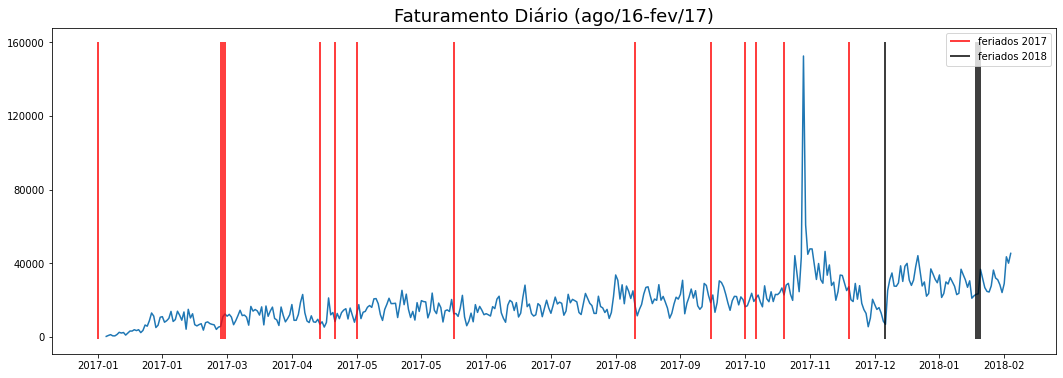

In [48]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Faturamento Diário (ago/16-fev/17)', fontsize=18)
plt.plot(df_pandas_serie_temporal_novo['price'])

# Plotando linhas verticais com as datas dos feriados e pontos facultativos
plt.vlines(pd.to_datetime(feriados_nacionais_2017), 
            ymin=-1000, ymax=16e4, color='r', label='feriados 2017')

plt.vlines(pd.to_datetime(feriados_nacionais_2018), 
            ymin=-1000, ymax=16e4, color='k', label='feriados 2018')

plt.legend()

ax.set_yticks(np.arange(0, 16e4 + 1, 4e4))

ax.xaxis.set_major_locator(ticker.IndexLocator(base=30, offset=-30))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))


A princípio podemos observar que, com exceção dos feriados de fevereiro (ponto facultativo de carnaval) as vendas tendem a cair durante os veriados.  
Agregaria mais aos estudos se tivéssemos um maior espaço de tempo para analisarmos, para verificar se certos padrões se repetem ano após ano.  
Outro ponto que pode ser interessante é adicionar os feriados referentes ao estado de São Paulo, já representa uma grande parte das vendas do dataset.

#### Datas importantes no varejo
Além dos feriados, pode ser interessante verificar se as datas comemorativas como dia das mães, namorados pode indicar um aumento nas vendas.

In [49]:
datas_varejo_2017 = [
    '2017-02-14', # dia dos namorados
    '2017-03-08', # dia internacional da mulher
    '2017-03-15', # dia do cliente
    '2017-04-28', # dia do frete gratis
    '2017-05-01', # dia mundial do trabalho
    '2017-05-14', # dia das mães
    '2017-06-12', # dia dos namorados
    '2017-07-20', # dia do amigo
    '2017-08-13', # dia dos pais
    '2017-10-12', # dia das crianças
    '2017-11-24', # blackfriday
    '2017-12-25', # Natal
    
]

# datas_varejo_2018 = [
#     '2018-02-14', # dia dos namorados
#     '2018-03-08', # dia internacional da mulher
#     '2018-03-15', # dia do cliente
#     '2018-04-28', # dia do frete gratis
#     '2018-05-01', # dia mundial do trabalho
#     '2018-05-13', # dia das mães
#     '2018-06-12', # dia dos namorados
#     '2018-07-20', # dia do amigo
#     '2018-08-12', # dia dos pais
#     '2018-10-12', # dia das crianças
#     '2018-11-23', # blackfriday
#     '2018-12-25', # Natal
# ]

datas_varejo_2018 = [
    '2018-02-14', # dia dos namorados
    # '2018-03-08', # dia internacional da mulher
    # '2018-03-15', # dia do cliente
    # '2018-04-28', # dia do frete gratis
    # '2018-05-01', # dia mundial do trabalho
    # '2018-05-13', # dia das mães
    # '2018-06-12', # dia dos namorados
    # '2018-07-20', # dia do amigo
    # '2018-08-12', # dia dos pais
    # '2018-10-12', # dia das crianças
    # '2018-11-23', # blackfriday
    # '2018-12-25', # Natal
]



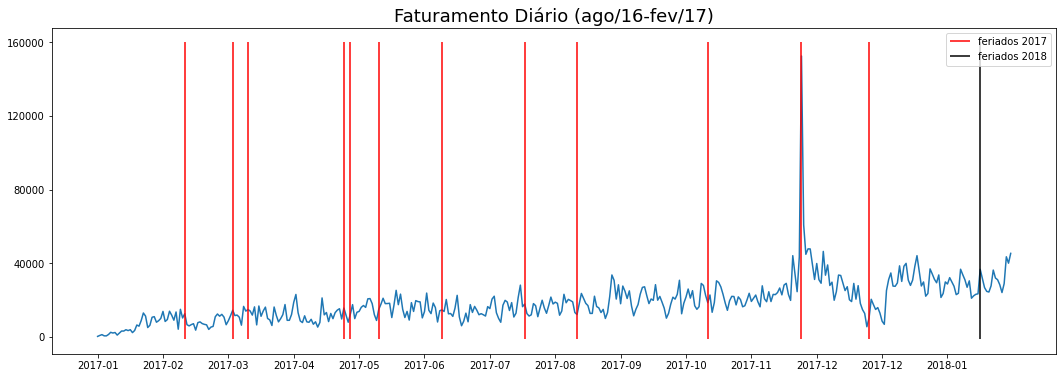

In [50]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Faturamento Diário (ago/16-fev/17)', fontsize=18)
plt.plot(df_pandas_serie_temporal_novo['price'])

# Plotando linhas verticais com as datas dos feriados e pontos facultativos
plt.vlines(pd.to_datetime(datas_varejo_2017), 
            ymin=-1000, ymax=16e4, color='r', label='feriados 2017')

plt.vlines(pd.to_datetime(datas_varejo_2018), 
            ymin=-1000, ymax=16e4, color='k', label='feriados 2018')

plt.legend()

ax.set_yticks(np.arange(0, 16e4 + 1, 4e4))

ax.xaxis.set_major_locator(ticker.IndexLocator(base=30, offset=-30))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

#### Médias Móveis

Analisando o comportamento das vendas dia a dia pode tornar difícil identificar uma tendência.  
Para contornar esse problema, vamos utilizar o conceito de médias móveis, que para esse caso vamos analisar média de 7, 14 e 21 dias.

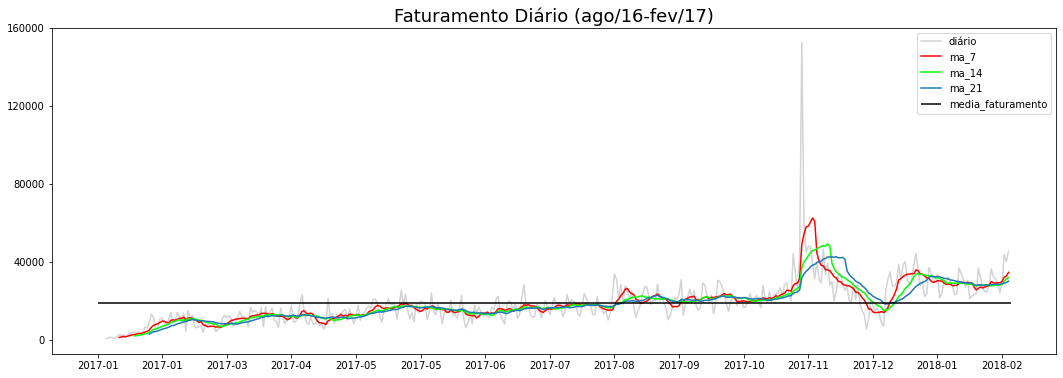

In [51]:
df_pandas_serie_temporal_novo['ma_7'] = df_pandas_serie_temporal_novo['price'].rolling(window=7).mean()
df_pandas_serie_temporal_novo['ma_14'] = df_pandas_serie_temporal_novo['price'].rolling(window=14).mean()
df_pandas_serie_temporal_novo['ma_21'] = df_pandas_serie_temporal_novo['price'].rolling(window=21).mean()

fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Faturamento Diário (ago/16-fev/17)', fontsize=18)
plt.plot(df_pandas_serie_temporal_novo[['price']], color='lightgrey')
plt.plot(df_pandas_serie_temporal_novo['ma_7'], color='red')
plt.plot(df_pandas_serie_temporal_novo['ma_14'], color='lime')
plt.plot(df_pandas_serie_temporal_novo['ma_21'])

media_preco = df_pandas_serie_temporal_novo['price'].mean()
ax.hlines(media_preco, xmin=pd.to_datetime('2017-01-01'), xmax=pd.to_datetime('2018-03-01'), color='k')

plt.legend(['diário', 'ma_7', 'ma_14', 'ma_21', 'media_faturamento'])

ax.set_yticks(np.arange(0, 16e4 + 1, 4e4))

ax.xaxis.set_major_locator(ticker.IndexLocator(base=30, offset=-30))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

Através das Médias podemos observar que existe uma tendência de crescimento dos faturamentos, uma vez que a partir de Agosto de 2017 as as médias móveis começam a ficar a cima da linha da média do faturamento.  
O mês de Novembro deste ano pode ter sido determinante para o crescimento subsequente.

#### Valores Numéricos  
Verificando a estatística dos valores numéricos do dataset.

In [52]:
numerical_columns = ['price', 'freight_value', 'order_item_id']
df_analise_novo[numerical_columns]\
    .summary()\
    .toPandas()

,summary,price,freight_value,order_item_id
0,count,66387,66387,66387
1,mean,118.87634612197022,19.28286290990662,1.1976893066413605
2,stddev,178.47899614694694,14.154327300246305,0.7321061099213123
3,min,1.2,0.0,1
4,25%,39.9,13.35,1
5,50%,72.9,15.98,1
6,75%,131.99,19.87,1
7,max,6735.0,314.4,21


Alguns pontos interessantes:
* Tanto preço (valor) como o custo do frete possuem uma distribuição bastante desbalanceadas (pouca ocorrência de valores altos) e possui um desvio padrão relativamente alto;
* Mesma constatação para a quantidade de itens no pedido (order_item_id), ou seja, a maioria das compras possui somente 1 item.  

Outra dúvida é, os itens com maiores valores também tem fretes mais caros, isso é, as duas variáveis estão correlacioandas?

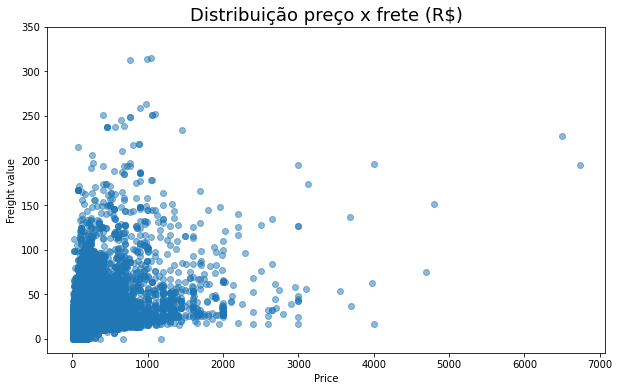

In [53]:
df_pandas_numerical = df_analise_novo[numerical_columns]\
    .toPandas()

plt.figure(figsize=(10, 6))
plt.title('Distribuição preço x frete (R$)', fontsize=18)
plt.scatter(data=df_pandas_numerical, x='price', y='freight_value', alpha=0.5)

plt.xlabel('Price')
plt.xticks(np.arange(0, 7001, 1000))

plt.ylabel('Freight value')
plt.yticks(np.arange(0, 351, 50))

plt.show()

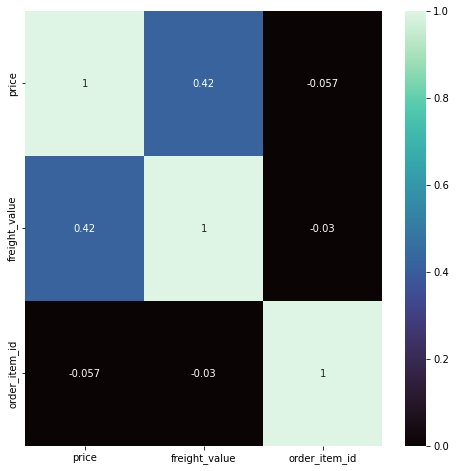

In [54]:
corr = df_pandas_numerical.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr, fmt='.2g', annot=True, cmap='mako', vmin=0)

plt.show()

Resposta é: existe uma **relação fraca**, portanto não significativo.  
Vamos analizar o preço dos produtos.

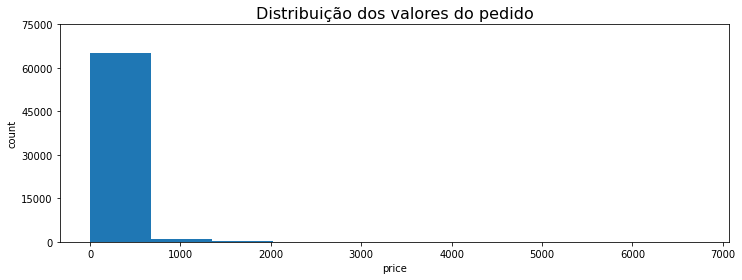

In [55]:
df_pandas_dist_price = df_analise_novo\
    .select('price')\
    .orderBy('price')\
    .toPandas()

plt.figure(figsize=(12, 4))
plt.title('Distribuição dos valores do pedido', fontsize=16)
plt.hist(data=df_pandas_dist_price, x='price')
plt.xlabel('price')
plt.ylabel('count')
plt.yticks(np.arange(0, 80001, 15000))
plt.show()

Como podemos notar, grande parte dos itens tem o preço até 2000.  
Podemos considerar todo valor maior que esse como outlier e verificar como trataremos antes de modelar.

## Conclusão  

Ao analisar o dataset, constatamos que a melhor estratégia para realizar o forecast é agrupar o faturamento por data, uma vez que as categorias estão dispersas e pode não agregar ao modelo.  Dos dados categóricos, a única que pode ser interessante explorar no modelo é a do estado - podemos adotar a estratégia de criar um modelo para cada estado ou somente um para todos, mas privilegiando o estado de São Paulo, já que é da onde vem a maior parte do faturamento.  
Os principais insights sobre o dataset são:
* A maioria dos pedidos vem predominantemente do estado de São Paulo;
* A maior parte dos vendedores se encontram na região sudeste, também com predominância do estado de São Paulo;
* Os clientes tendem a realizar os pedidos durante a semana (de segunda à sexta);
* Existe uma tendência positiva nas vendas - ao longo da série o faturamento vai crescendo, mesmo que seja lentamente;
* A black friday de 2017 impactou positivamente o negócio - além do recorde de vendas do período observado, a partir deste ponto o faturamento passou a ficar acima da média de faturamento do período (mesmo com a queda do final do ano).


Identificamos também alguns candidatos a features para ajudar na modelagem:
* Feriados e pontos facultativos;
* Eventos especiais (dias dos pais, dia das mães, blackfriday e etc);
* dia da semana;
* média móveis com 7, 14 e 21 dias de janela;
* venda do dia anterior.

In [56]:
spark.stop()